In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [3]:
def generate_data(num_samples, min_points=5, max_points=20, noise_std=0.5):
    """
    Generate synthetic data for trendlines with noise.
    
    Args:
        num_samples (int): Number of samples to generate.
        min_points (int): Minimum number of points per sample.
        max_points (int): Maximum number of points per sample.
        noise_std (float): Standard deviation of the Gaussian noise.
    
    Returns:
        list of dict: Each dict contains 'x', 'y', 'slope', 'intercept'.
    """
    data = []
    for _ in range(num_samples):
        # Randomly determine the number of points
        num_points = np.random.randint(min_points, max_points + 1)
        
        # Generate x values
        x = np.random.uniform(-10, 10, num_points)
        x.sort()  # Sorting x values for better visualization (optional)
        
        # Randomly generate slope and intercept
        slope = np.random.uniform(-5, 5)
        intercept = np.random.uniform(-10, 10)
        
        # Generate y values with noise
        noise = np.random.normal(0, noise_std, num_points)
        y = slope * x + intercept + noise
        
        # Save to data
        data.append({'x': x, 'y': y, 'slope': slope, 'intercept': intercept})
    
    return data

# Generate some example data
example_data = generate_data(10)
train_data = generate_data(100000)
val_data = generate_data(200)

In [4]:
class TrendlineDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        x = torch.tensor(sample['x'], dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(sample['y'], dtype=torch.float32).unsqueeze(-1)
        xy = torch.cat([x, y], dim=1)  # Combine x and y into a single tensor
        target = torch.tensor([sample['slope'], sample['intercept']], dtype=torch.float32)
        return xy, target


# Generate data
train_dataset = TrendlineDataset(train_data)
val_dataset = TrendlineDataset(val_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: x)

In [5]:
class RNNRegressor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=1):
        super(RNNRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Output layer
        self.fc = nn.Linear(hidden_dim, 2)  # Output slope and intercept

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        _, (hidden, _) = self.rnn(x)  # Get the final hidden state
        hidden = hidden[-1]  # Use the last layer's hidden state
        output = self.fc(hidden)  # Predict slope and intercept
        return output

def visualize_predictions(model, data, title, num_samples=5):
    """
    Visualize the predictions of the model on sample data.
    
    Args:
        model (nn.Module): Trained or untrained model.
        data (list of dict): Test dataset (list of trendline samples).
        title (str): Title for the plot.
        num_samples (int): Number of samples to visualize.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Select a few samples to visualize
    samples = data[:num_samples]
    
    fig, axs = plt.subplots(num_samples, 1, figsize=(8, 4 * num_samples))
    if num_samples == 1:
        axs = [axs]  # Ensure axs is iterable for a single sample

    with torch.no_grad():
        for i, sample in enumerate(samples):
            # Prepare input
            x = torch.tensor(sample['x'], dtype=torch.float32).unsqueeze(-1)
            y = torch.tensor(sample['y'], dtype=torch.float32).unsqueeze(-1)
            xy = torch.cat([x, y], dim=1).unsqueeze(0).to(device)  # Add batch dimension
            
            # Get prediction
            pred_slope, pred_intercept = model(xy).squeeze(0).cpu().numpy()
            
            # Ground truth
            true_slope = sample['slope']
            true_intercept = sample['intercept']
            
            # Generate points for visualization
            x_vals = np.linspace(min(sample['x']), max(sample['x']), 100)
            true_y_vals = true_slope * x_vals + true_intercept
            pred_y_vals = pred_slope * x_vals + pred_intercept
            
            # Plot the points and lines
            axs[i].scatter(sample['x'], sample['y'], label='Data Points', color='blue')
            axs[i].plot(x_vals, true_y_vals, label='True Line', color='green', linestyle='--')
            axs[i].plot(x_vals, pred_y_vals, label='Predicted Line', color='red')
            axs[i].set_title(f"Sample {i + 1}\nTrue Slope: {true_slope:.2f}, True Intercept: {true_intercept:.2f}\n"
                             f"Predicted Slope: {pred_slope:.2f}, Predicted Intercept: {pred_intercept:.2f}")
            axs[i].legend()
            axs[i].grid()
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()
    
def train_rnn(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            # Unpack and send to device
            batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)  # Sort by sequence length
            sequences, targets = zip(*batch)
            sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
            targets = torch.stack(targets).to(device)

            # Pad sequences to batch max length
            sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True).to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
                sequences, targets = zip(*batch)
                sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
                targets = torch.stack(targets).to(device)

                sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True).to(device)

                outputs = model(sequences)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")


# Initialize and train the model
model = RNNRegressor()



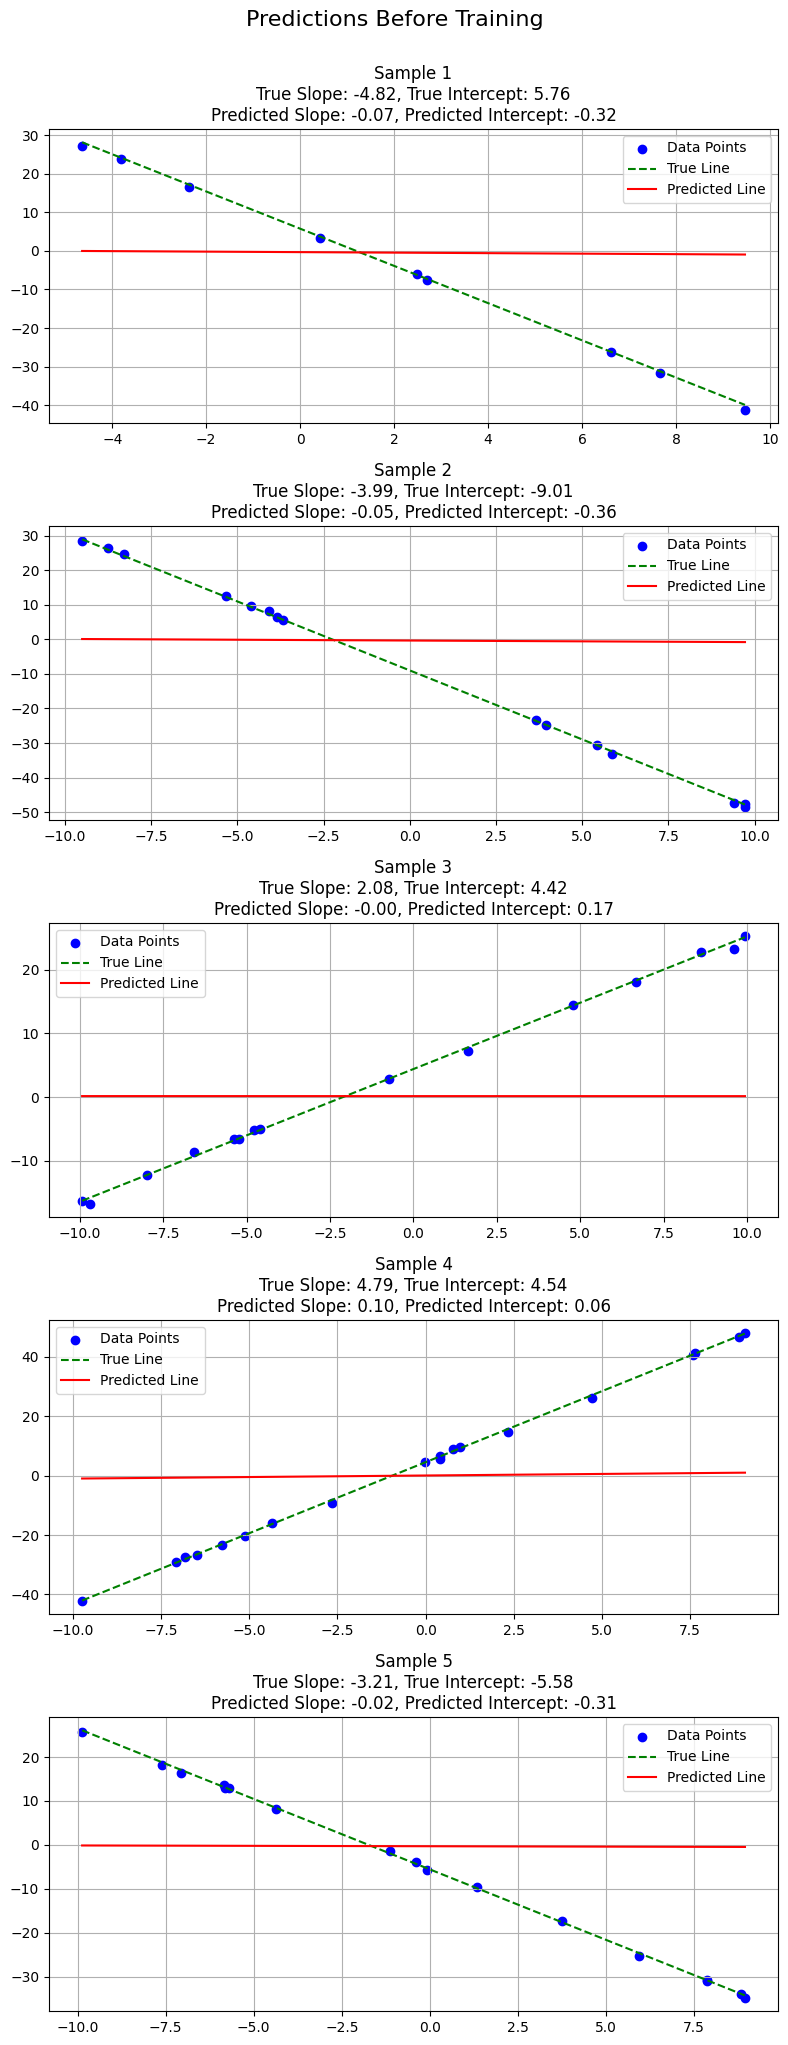

In [6]:
visualize_predictions(model, train_data, title="Predictions Before Training")


In [7]:
train_rnn(model, train_loader, val_loader)

/tmp/ipykernel_29/1345758399.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]


Epoch 1/20, Train Loss: 0.9520
Validation Loss: 0.1827


/tmp/ipykernel_29/1345758399.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]


Epoch 2/20, Train Loss: 0.1274
Validation Loss: 0.0995
Epoch 3/20, Train Loss: 0.1076
Validation Loss: 0.1070
Epoch 4/20, Train Loss: 0.0984
Validation Loss: 0.1083
Epoch 5/20, Train Loss: 0.0816
Validation Loss: 0.2020
Epoch 6/20, Train Loss: 0.0771
Validation Loss: 0.0749
Epoch 7/20, Train Loss: 0.0722
Validation Loss: 0.1788
Epoch 8/20, Train Loss: 0.0645
Validation Loss: 0.0519
Epoch 9/20, Train Loss: 0.0593
Validation Loss: 0.0702
Epoch 10/20, Train Loss: 0.0617
Validation Loss: 0.0606
Epoch 11/20, Train Loss: 0.0590
Validation Loss: 0.0741
Epoch 12/20, Train Loss: 0.0531
Validation Loss: 0.0552
Epoch 13/20, Train Loss: 0.0495
Validation Loss: 0.0583
Epoch 14/20, Train Loss: 0.0471
Validation Loss: 0.0632
Epoch 15/20, Train Loss: 0.0456
Validation Loss: 0.0382
Epoch 16/20, Train Loss: 0.0440
Validation Loss: 0.0517
Epoch 17/20, Train Loss: 0.0418
Validation Loss: 0.0450
Epoch 18/20, Train Loss: 0.0400
Validation Loss: 0.0628
Epoch 19/20, Train Loss: 0.0401
Validation Loss: 0.0493


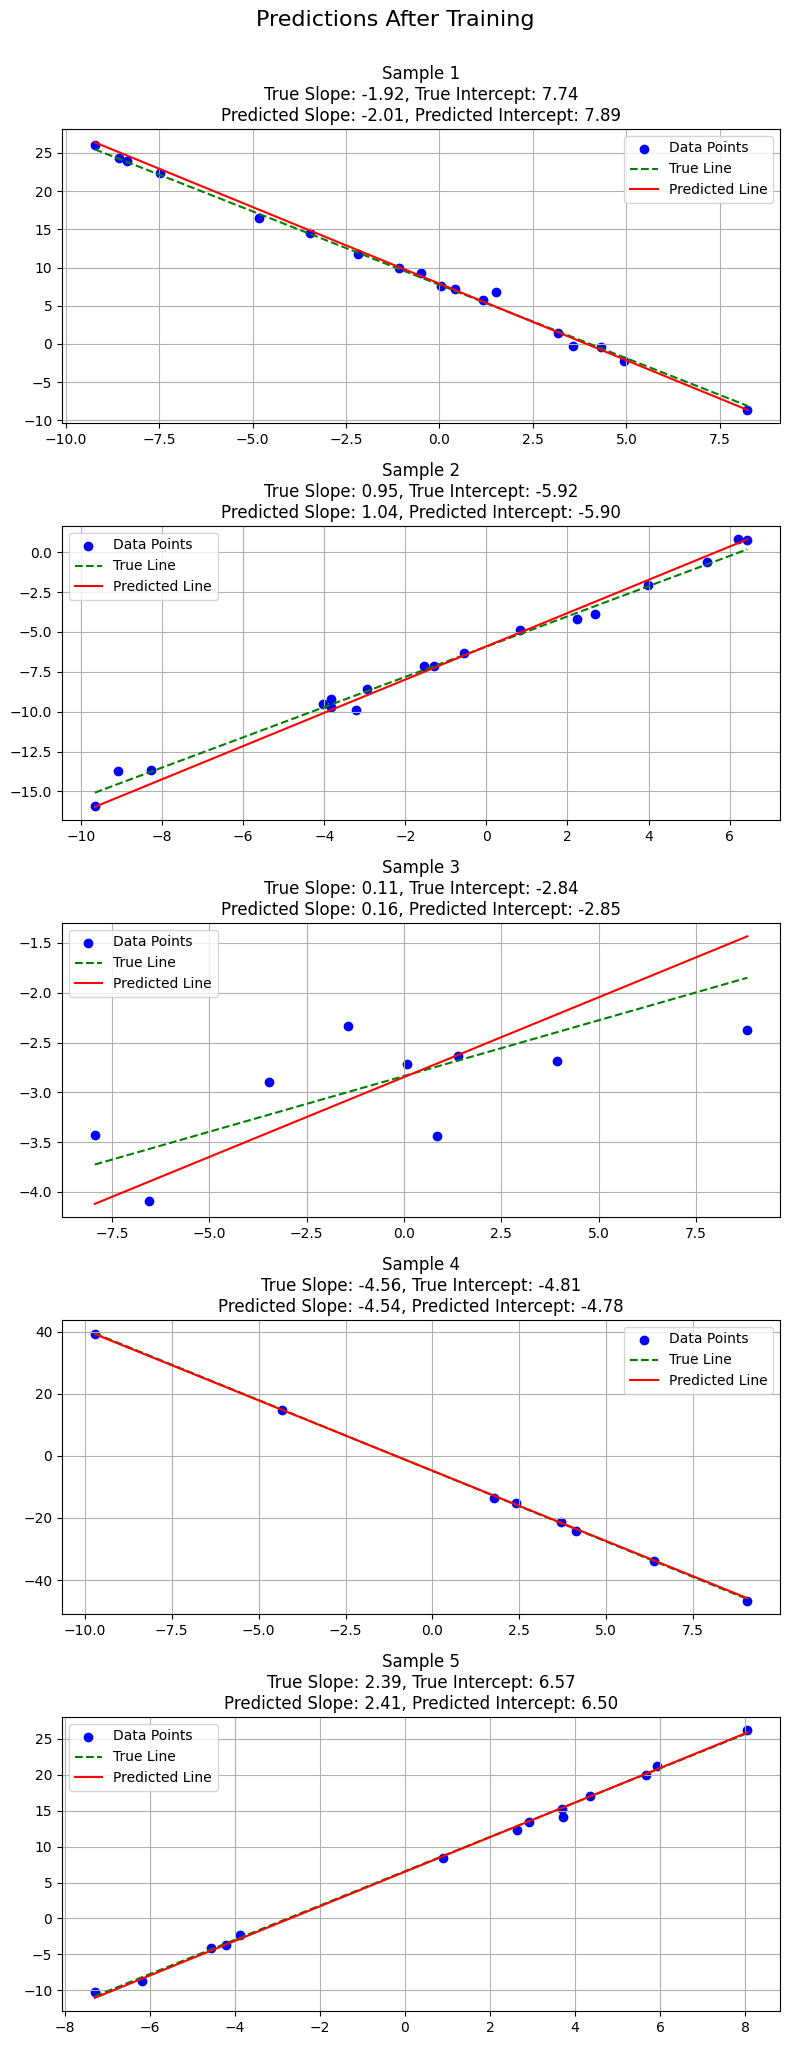

In [11]:
# Visualize predictions after training
visualize_predictions(model, val_data[10:], title="Predictions After Training")


In [43]:
def generate_data(num_samples, min_points=10, max_points=20, noise_std=0.5):
    """
    Generate synthetic data for trendlines with noise.
    
    Args:
        num_samples (int): Number of samples to generate.
        min_points (int): Minimum number of points per sample.
        max_points (int): Maximum number of points per sample.
        noise_std (float): Standard deviation of the Gaussian noise.
    
    Returns:
        list of dict: Each dict contains 'x', 'y', 'slope', 'intercept'.
    """
    data = []
    for _ in range(num_samples):
        # Randomly determine the number of points
        num_points = np.random.randint(min_points, max_points + 1)
        
        # Generate x values
        x = np.random.uniform(-10, 10, num_points)
        x.sort()  # Sorting x values for better visualization (optional)
        
        # Randomly generate slope and intercept
        slope = np.random.uniform(-5, 5)
        intercept = np.random.uniform(-10, 10)
        
        # Generate y values with noise
        noise = np.random.normal(0, noise_std, num_points)
        y = slope * x + intercept + noise
        addon = np.zeros(24-num_points)
        # Save to data
        data.append({'x': np.concatenate((addon,x)), 'y': np.concatenate((addon,y)), 'slope': slope, 'intercept': intercept})
    
    return data

# Generate some example data
example_data = generate_data(10)
train_data = generate_data(1000)
val_data = generate_data(200)
# print(example_data)

class TrendlineDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        x = torch.tensor(sample['x'], dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(sample['y'], dtype=torch.float32).unsqueeze(-1)
        xy = torch.cat([x, y], dim=1)  # Combine x and y into a single tensor
        target = torch.tensor([sample['slope'], sample['intercept']], dtype=torch.float32)
        return xy, target


# Generate data
train_dataset = TrendlineDataset(train_data)
val_dataset = TrendlineDataset(val_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: x)

class CNN(nn.Module): #lets assume input data is 32x2, so 256 data values, shape [2,32]
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv_layer1 = nn.Conv1d(in_channels=2, out_channels=10, kernel_size=5)# now shape is [10,32-4=28]
        self.conv_layer2 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=5) # [10,24]
        self.max_pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2) # [10, 12]
        
        self.conv_layer3 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=5) # [10,8]
        self.conv_layer4 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=5) # [10, 4]
        
        self.fc1 = nn.Linear(40, 20)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(20, 2)

        # RNN layer
        # self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Output layer
        # self.fc = nn.Linear(hidden_dim, 2)  # Output slope and intercept

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

def train_cnn(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)  
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            # Unpack and send to device
            # batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)  # Sort by sequence length
            sequences, targets = zip(*batch)
            print(type(sequences))
            print(sequences)
            # sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
            # targets = torch.stack(targets).to(device)

            # Pad sequences to batch max length
            # sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True).to(device)

            optimizer.zero_grad()
            # print(sequences)
            # print(type(sequences))
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                sequences, targets = zip(*batch)
                sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
                targets = torch.stack(targets).to(device)

                outputs = model(sequences)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")



In [44]:
model = CNN()
train_cnn(model, train_loader, val_loader)

<class 'torch.Tensor'>
tensor([[[  0.0000,   0.0000,   0.0000,  ...,   3.8721,   8.7899,   9.2442],
         [  0.0000,   0.0000,   0.0000,  ...,   7.2885,  12.0331,  12.8873]],

        [[  0.0000,   0.0000,   0.0000,  ...,   5.7857,   8.1932,   9.3746],
         [  0.0000,   0.0000,   0.0000,  ...,  -9.9949,  -9.9753,  -9.3151]],

        [[  0.0000,   0.0000,   0.0000,  ...,   8.6410,   8.7465,   9.4675],
         [  0.0000,   0.0000,   0.0000,  ...,  25.2753,  24.5157,  26.9738]],

        ...,

        [[  0.0000,   0.0000,   0.0000,  ...,   6.0936,   8.3574,   9.2301],
         [  0.0000,   0.0000,   0.0000,  ..., -20.7678, -25.2812, -28.4089]],

        [[  0.0000,   0.0000,   0.0000,  ...,   7.1755,   7.8074,   8.0335],
         [  0.0000,   0.0000,   0.0000,  ...,  34.4803,  36.9871,  38.5879]],

        [[  0.0000,   0.0000,   0.0000,  ...,   6.8602,   6.8831,   8.6588],
         [  0.0000,   0.0000,   0.0000,  ...,  21.8761,  21.8917,  28.4952]]])


RuntimeError: Calculated padded input size per channel: (4). Kernel size: (5). Kernel size can't be greater than actual input size

In [37]:
# Use transforms.compose method to reformat images for modeling,
# and save to variable all_transforms for later use
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])
# Create Training dataset
train_dataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             transform = all_transforms,
                                             download = True)

# Create Testing dataset
test_dataset = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            transform = all_transforms,
                                            download=True)

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

  1% 1.67M/170M [00:42<1:11:05, 39.6kB/s]


KeyboardInterrupt: 